This notebook is part of the PyImageJ [Tutorial Series](./notebooks.rst), and assumes familiarity with the ImageJ API. Dedicated tutorials for ImageJ can be found [here](https://imagej.net/tutorials/).S

# 12 Troubleshooting

This notebook covers some basic troubleshooting with PyImageJ. Let's initalize ImageJ before exploring some troublehsooting options.


In [1]:
import imagej

# initialize ImageJ
ij = imagej.init()
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.13.1/1.54d


## 12.1 I can't pass my numpy image to an `Op`

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many `Op`s, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [2]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)
<java class 'net.imagej.DefaultDataset'>
[[266. 148.  54.]
 [251. 169.  41.]
 [246. 168.  26.]
 [257. 148.  34.]
 [250. 168.  37.]]
Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.ma

We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

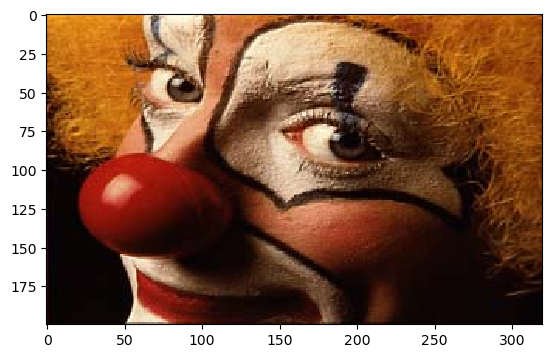

In [3]:
from skimage import io

# Create a numpy image using scikit
img = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(img)
print(type(ij.py.to_java(img)))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


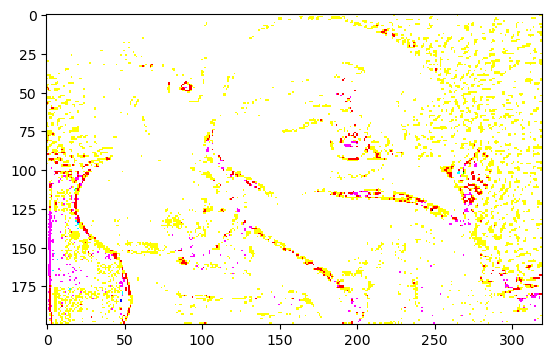

In [4]:
import numpy as np

result = np.zeros(img.shape) # HINT: Uses float dtype, for more accurate noising.

imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(img))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

Uh oh. Something's off with the data values—see next section!

If you need to troubleshoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

If you need to troubleshoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

## 12.2 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats of [0..255] for integers

This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's be certain which is the culprit by checking some values of `result`:

In [5]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

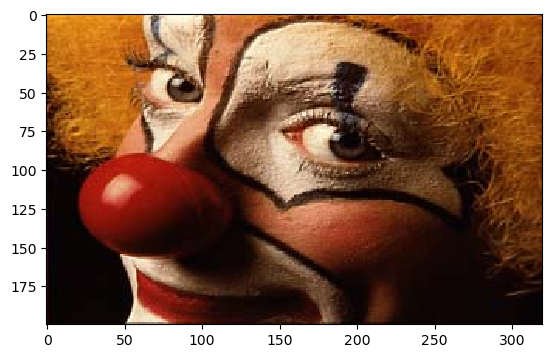

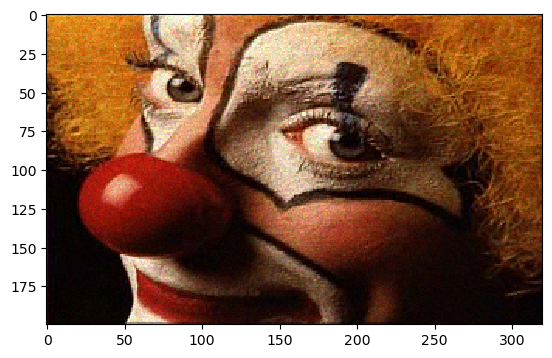

In [6]:
ij.py.show(img.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.

If you need to troubleshoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [7]:
# print is required to render new lines
print(ij.op().help('multiply'))